# Parametric Alternative Comparison
Statistic Analysis of Simulation Data

In [90]:
# author: Leopold Mueller (leopold_mueller@gmx.de)
# version: 2024-06.1

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import to_rgba
import os

from scipy import stats as stats
from scipy.stats import rv_continuous, beta, genextreme, rv_histogram, linregress
import scipy.optimize as opt

# data sheets
path = r"C:\Users\Leopold\Documents\Testprojekte\Uni\SE Project\Sim_runs\model_data_run02.xlsx"

# number format of numpy arrays
np.set_printoptions(formatter={'float_kind':"{:.3f}".format})
pd.options.display.float_format = '{:,.0f}'.format

## Data

In [2]:
# excel import
cost_df_alt1 = pd.read_excel(path, sheet_name="alt1_data").astype(float)
cost_df_alt2 = pd.read_excel(path, sheet_name="alt2_data").astype(float)
cost_df_alt3 = pd.read_excel(path, sheet_name="alt3_data").astype(float)
cost_df_alt4 = pd.read_excel(path, sheet_name="alt4_data").astype(float)


In [3]:
# compare graphs
cost_compare = pd.DataFrame({"Combined bridge": cost_df_alt1[cost_df_alt1.columns[0]], "Separate bridges": cost_df_alt2[cost_df_alt2.columns[0]], "Immersed tunnel": cost_df_alt3[cost_df_alt3.columns[0]], "Bored tunnel": cost_df_alt4[cost_df_alt4.columns[0]]})
cost_compare = cost_compare.apply(pd.to_numeric)
cost_compare = cost_compare.replace("nan", np.nan)
cost_compare

,Combined bridge,Separate bridges,Immersed tunnel,Bored tunnel
0,"40,427,000","50,087,000","11,772,000","11,666,000"
1,"40,930,000","50,791,000","12,066,300","11,666,000"
2,"41,433,000","51,495,000","12,361,000","11,666,000"
3,"41,936,000","52,199,000","12,655,000","11,958,000"
4,"42,439,000","52,905,000","12,949,000","11,958,000"
...,...,...,...,...
859,NaN,NaN,"33,210,000",NaN
860,NaN,NaN,"34,020,000",NaN
861,NaN,NaN,"34,830,000",NaN
862,NaN,NaN,"35,640,000",NaN


In [4]:
# change data structure to include keys
cost_keys = pd.melt(cost_compare, var_name='alternative', value_name='material_costs')
cost_keys = cost_keys.dropna()
cost_keys = cost_keys.reset_index(drop=True)
cost_keys

,alternative,material_costs
0,Combined bridge,"40,427,000"
1,Combined bridge,"40,930,000"
2,Combined bridge,"41,433,000"
3,Combined bridge,"41,936,000"
4,Combined bridge,"42,439,000"
...,...,...
2911,Bored tunnel,"40,663,000"
2912,Bored tunnel,"40,663,000"
2913,Bored tunnel,"41,587,000"
2914,Bored tunnel,"41,587,000"


In [5]:
# detailed parameter data (add the joint parameter road_width as new column for each alternative)

# extract the column from each DataFrame
road_width1 = cost_df_alt1.iloc[:, 2]
road_width2 = cost_df_alt2.iloc[:, 2]
road_width3 = cost_df_alt3.iloc[:, 2]
road_width4 = cost_df_alt4.iloc[:, 2]

# Combine the data into a new DataFrame
road_width_combined = pd.DataFrame({'road_width': pd.concat([road_width1, road_width2, road_width3, road_width4], ignore_index=True)})
road_width_costs = cost_keys.copy()

road_width_costs['road_width'] = road_width_combined
road_width_costs['road_width'] = road_width_costs['road_width'].astype(str)
road_width_costs


,alternative,material_costs,road_width
0,Combined bridge,"40,427,000",8.0
1,Combined bridge,"40,930,000",8.0
2,Combined bridge,"41,433,000",8.0
3,Combined bridge,"41,936,000",8.0
4,Combined bridge,"42,439,000",8.0
...,...,...,...
2911,Bored tunnel,"40,663,000",10.0
2912,Bored tunnel,"40,663,000",10.0
2913,Bored tunnel,"41,587,000",10.0
2914,Bored tunnel,"41,587,000",10.0


## Plots

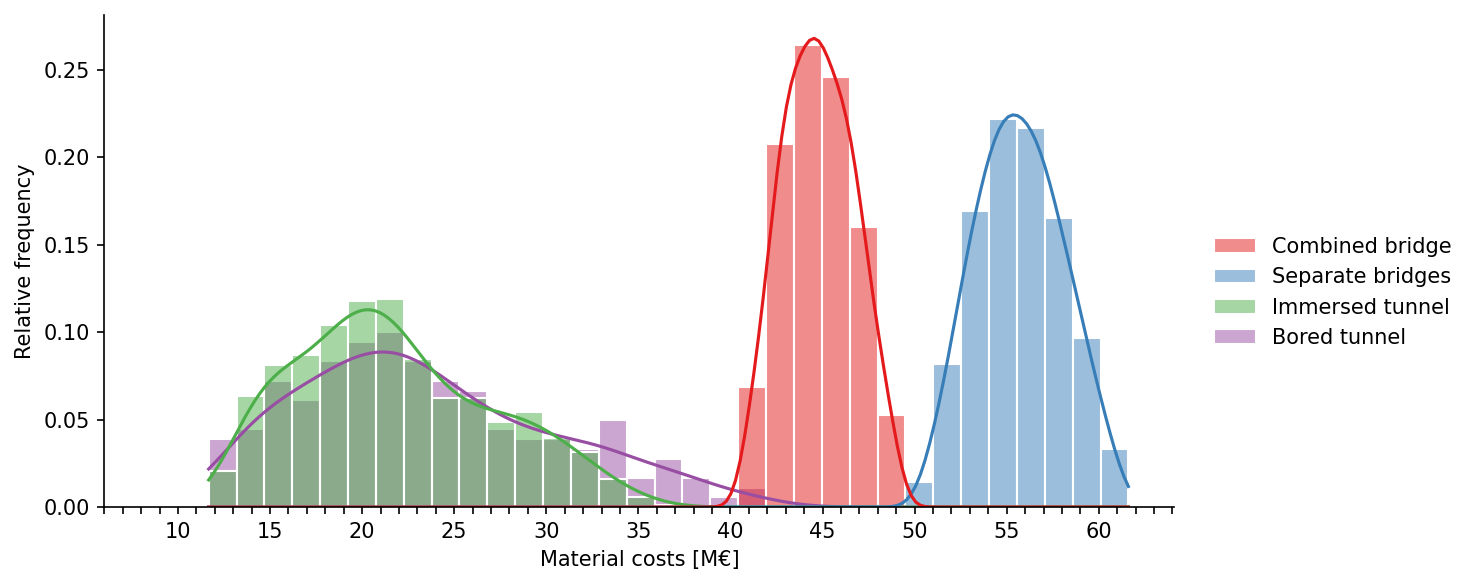

In [6]:
# plot histogram
cost_hist = sns.displot(data=cost_compare, kde=True, element="bars", edgecolor="white", palette="Set1", stat="percent", common_norm=False, height=4, aspect=2, binwidth=1500000)
cost_hist.figure.set_dpi(150)
cost_hist.set(xlabel="Material costs [M€]", ylabel="Relative frequency", xlim=(6000000, None))

# modifying axes
for ax in cost_hist.axes.flat:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1000000))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x/1000000)))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "{:,.2f}".format(x/100)))

    # modifying ticks
    for ind, label in enumerate(ax.get_xticklabels()):
        if ind % 5 == 0:  # every 5th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)

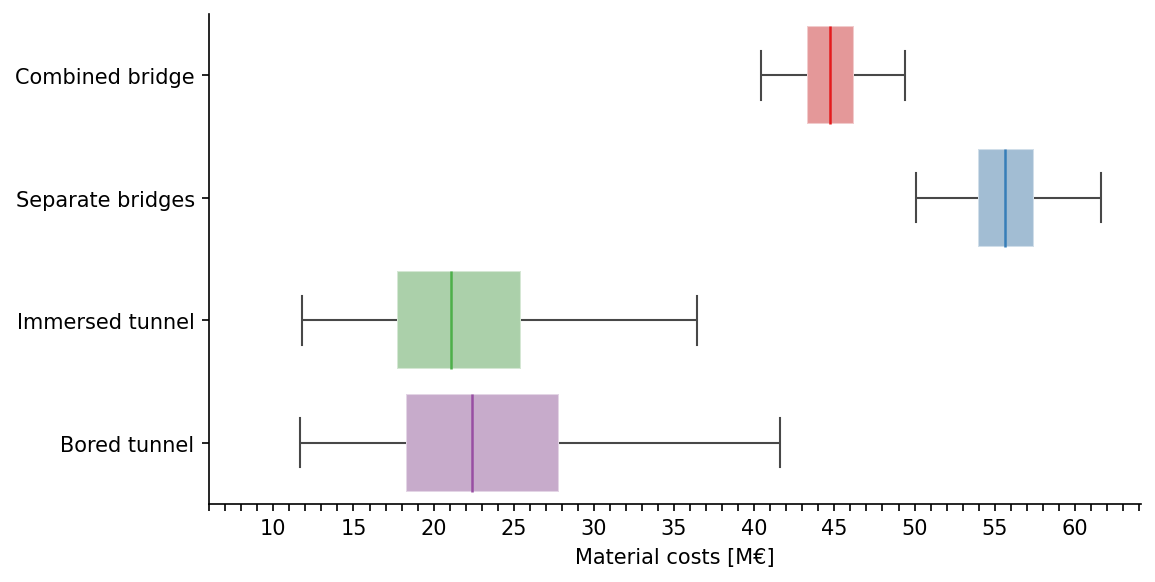

In [7]:

# plot boxplot

cost_box = sns.catplot(data=cost_keys, x="material_costs", y="alternative", kind="box", hue="alternative", palette="Set1", medianprops={"color": "white", "linewidth": 1.2}, boxprops={"edgecolor": "white", "alpha": 0.5}, height=4, aspect=2)
cost_box.figure.set_dpi(150)
cost_box.set(xlabel="Material costs [M€]", ylabel="", xlim=(6000000, None))

# modify the median line colors
median_colors = sns.color_palette("Set1").as_hex.__self__
ax = cost_box.ax
for i, line in enumerate(ax.lines):
    # median lines are at positions 4, 10, 16, ... (6*i + 4)
    if (i - 4) % 6 == 0:
        median_index = (i - 4) // 6
        line.set_color(median_colors[median_index % len(median_colors)])

# modifying axes
for ax in cost_box.axes.flat:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1000000))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x/1000000)))

    # modifying ticks
    for ind, label in enumerate(ax.get_xticklabels()):
        if ind % 5 == 0:  # every 5th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)


['road_width = 8.0', 'road_width = 9.0', 'road_width = 10.0']


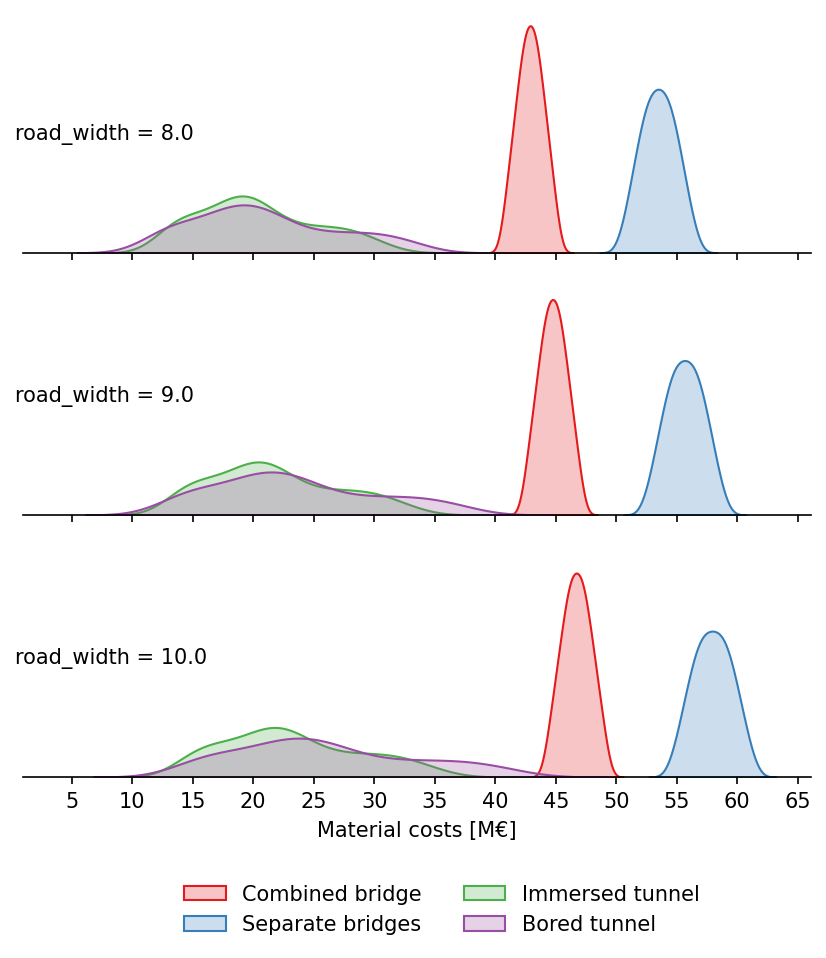

In [8]:
# ridgeplot

road_width_plot = sns.FacetGrid(data=road_width_costs, row="road_width", hue="alternative", palette="Set1", height=2, aspect=3)
road_width_plot.figure.set_dpi(150)

road_width_plot.map_dataframe(sns.kdeplot, x="material_costs", fill=True)
road_width_plot.set_titles(template="")
road_width_plot.set(xlabel="Material costs [M€]", ylabel="", xlim=(1000000, None), yticks=[])


# labels for subplots
labels = list(set(road_width_costs.road_width))
for i, label in enumerate(labels):
    labels[i] = "road_width = "+str(label)
print(labels)

for ax,l in zip(road_width_plot.axes[:,0], labels):
        ax.set_ylabel(l, rotation = 0, ha="left", va="center")

# position of subplots
road_width_plot.figure.subplots_adjust(wspace=0, hspace=0.1)


# modifying axes
for ax in road_width_plot.axes.flat:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5000000))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "{:,.0f}".format(x/1000000)))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: "{:,.2f}".format(x/100)))

    # modifying ticks
    for ind, label in enumerate(ax.get_xticklabels()):
        if ind % 1 == 0:  # every 1st label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)

road_width_plot.despine(left=True)

# adjusting legend
road_width_plot.add_legend()
sns.move_legend(road_width_plot, "lower center", bbox_to_anchor=(0.45,-0.1), ncol=2, title=None, frameon=False)

## Analysis

In [20]:
# statistics
# additional ressources:
#               https://www.statology.org/interquartile-range-vs-standard-deviation/
# get descriptive statistics
cost_analysis = cost_compare[["Combined bridge", "Separate bridges", "Immersed tunnel", "Bored tunnel"]].describe()

# calculate the IQR for each column
def add_iqr_row(raw_data, statistics_data):
    iqr = raw_data.apply(lambda x: x.quantile(0.75) - x.quantile(0.25))
    statistics_data.loc["iqr"] = iqr
    return statistics_data

cost_analysis = add_iqr_row(cost_compare, cost_analysis)
cost_analysis

,Combined bridge,Separate bridges,Immersed tunnel,Bored tunnel
count,756,756,864,540
mean,"44,781,124","55,695,435","21,741,788","23,456,883"
std,"1,926,974","2,376,874","5,353,721","6,860,340"
min,"40,427,000","50,087,000","11,772,000","11,666,000"
25%,"43,305,750","53,932,250","17,706,500","18,292,500"
50%,"44,736,000","55,640,500","21,077,500","22,385,500"
75%,"46,217,750","57,434,500","25,457,500","27,830,000"
max,"49,386,000","61,608,000","36,450,000","41,587,000"
iqr,"2,912,000","3,502,250","7,751,000","9,537,500"


In [52]:
# staitsics road_width

# prepare data
# get unique road widths
road_widths = road_width_costs["road_width"].unique()

# create a dictionary to hold DataFrames for each road width
road_width_dfs = {}

for width in road_widths:
    road_width_dfs[width] = road_width_costs[road_width_costs["road_width"] == width].reset_index(drop=True)
#road_width_dfs.keys()

# describe dfs
road_width_analysis = pd.DataFrame(columns=["road_width", "measure"])

for i in range(len(road_width_dfs)):
    temp_data = road_width_dfs[list(road_width_dfs.keys())[i]]
    temp_alt = temp_data.pivot(columns="alternative", values="material_costs")
    temp_analysis = temp_alt[["Combined bridge", "Separate bridges", "Immersed tunnel", "Bored tunnel"]].describe()
    temp_analysis = add_iqr_row(temp_alt, temp_analysis)
    
    # export median
    road_width_analysis = pd.concat([road_width_analysis, pd.DataFrame({"road_width": [list(road_width_dfs.keys())[i]]})], ignore_index=True)
    road_width_analysis.loc[road_width_analysis.index[2*i], "measure"] = "Median"
    for col in temp_analysis.columns:
        road_width_analysis.loc[2*i, col] = temp_analysis.loc["50%"][col]


    # export iqr
    road_width_analysis = pd.concat([road_width_analysis, pd.DataFrame({"road_width": [list(road_width_dfs.keys())[i]]})], ignore_index=True)
    road_width_analysis.loc[road_width_analysis.index[2*i+1], "measure"] = "IQR"
    for col in temp_analysis.columns:
        road_width_analysis.loc[2*i+1, col] = temp_analysis.loc["iqr"][col]

road_width_analysis

,road_width,measure,Combined bridge,Separate bridges,Immersed tunnel,Bored tunnel
0,8.0,Median,"42,890,500","53,482,500","19,630,500","20,039,500"
1,8.0,IQR,"1,564,250","2,164,500","7,063,000","8,132,500"
2,9.0,Median,"44,747,500","55,659,000","21,010,650","22,385,500"
3,9.0,IQR,"1,666,750","2,285,250","7,655,000","9,093,750"
4,10.0,Median,"46,705,500","57,943,500","22,440,000","24,729,500"
5,10.0,IQR,"1,741,750","2,418,750","8,215,250","10,053,750"


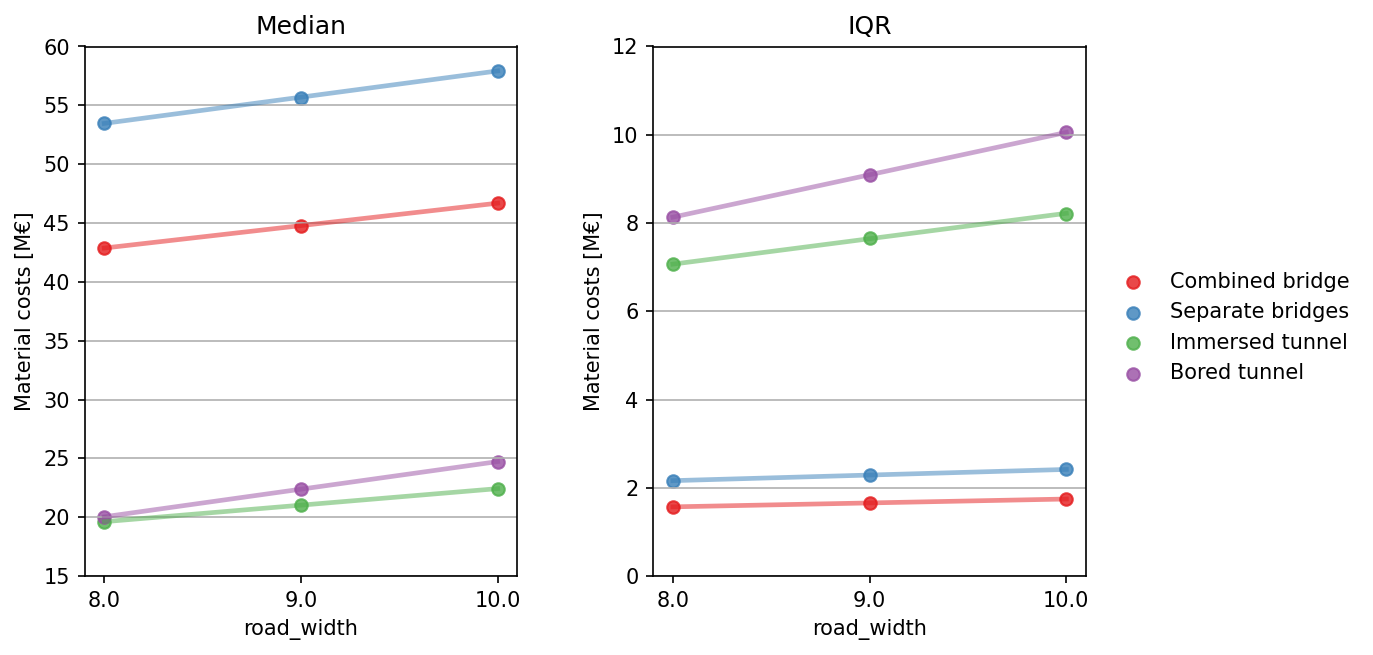

In [110]:
# Create plot for road_width analysis

# Convert numeric columns to float
numeric_cols = ['road_width', 'Combined bridge', 'Separate bridges', 'Immersed tunnel', 'Bored tunnel']
road_width_analysis[numeric_cols] = road_width_analysis[numeric_cols].astype(float)

# Separate the DataFrame into Median and IQR subsets
median_data = road_width_analysis[road_width_analysis['measure'] == 'Median'].copy()
iqr_data = road_width_analysis[road_width_analysis['measure'] == 'IQR'].copy()

# Set up the plot
plt.figure(figsize=(8, 5), dpi=150)

# Define a color palette for the lines
sns.set_palette("Set1")

# Plotting for Median
plt.subplot(1, 2, 1)
for i, col in enumerate(['Combined bridge', 'Separate bridges', 'Immersed tunnel', 'Bored tunnel']):
    sns.regplot(data=median_data, x='road_width', y=col, scatter=True, fit_reg=True, label=col,
                ci=None, line_kws={'alpha': 0.5})
plt.title('Median')
plt.xticks(ticks=median_data['road_width'].unique(), labels=median_data['road_width'].unique())
plt.yticks(ticks=plt.gca().get_yticks(), labels=["{:,.0f}".format(y/1000000) for y in plt.gca().get_yticks()])
plt.xlabel("road_width")
plt.ylabel("Material costs [M€]")
plt.grid(axis="y")


# Plotting for IQR
plt.subplot(1, 2, 2)
for i, col in enumerate(['Combined bridge', 'Separate bridges', 'Immersed tunnel', 'Bored tunnel']):
    sns.regplot(data=iqr_data, x='road_width', y=col, scatter=True, fit_reg=True, label=col,
                ci=None, line_kws={'alpha': 0.5})
plt.title('IQR')
plt.xticks(ticks=iqr_data['road_width'].unique(), labels=iqr_data['road_width'].unique())
plt.yticks(ticks=plt.gca().get_yticks(), labels=["{:,.0f}".format(y/1000000) for y in plt.gca().get_yticks()])
plt.xlabel("road_width")
plt.ylabel("Material costs [M€]")
plt.grid(axis="y")

# Adjust layout and display the plots
plt.tight_layout(pad=3.0)

# Create a common legend outside of the second plot on the left side
handles, labels = plt.gca().get_legend_handles_labels()
plt.figlegend(handles, labels, loc='center right', bbox_to_anchor=(1.18, 0.5), title=None, frameon=False)

plt.show()